# Tempo de processamento em função do tamanho do janelamento

Nesse Jupyter, vamos testar o tempo que a Raspberry leva para aplicar o DaS e extrair as features em função do tamanho do janelamento. O tempo de classificação não é alterado pelo tamanho do janelamento já que o tamanho do vetor de features possui valor fixo para qualquer tamanho de janela.

Como o librosa não preserva a profundidade de bits de um áudio, eu vou usar o próprio ReSpeaker para gravar algumas janelas nesse Jupyter. Assim, eu garanto que todo o processamento vai ser feito em cima de amostras INT16. Caso eu usasse arquivos WAVs prontos, correria o risco de não obter o resultado verdadeiro, pois o librosa transformaria tudo em FLOAT32.

In [1]:
import sys
import time
import os
import pyaudio
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

sys.path.append("/home/pi/Programming/IC2019/Raspberry/Python/")
sys.path.append("/home/pi/Programming/IC2019/DOA/Python/")

from SimularArrayMicrofonesClass import SimularArrayMicrofones
from delayAndSum import delayAndSum as DaS
from extracaoFeatures import extrairFeaturesUnicoFrame as ExtrairFeatures

/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [14]:
# DEFININDO ALGUNS PARÂMETROS PARA PLOTAR GRÁFICOS
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
params = {'figure.figsize': [10, 5], 
          'axes.labelsize': 10,
          'axes.titlesize':14, 
          'font.size': 10,
          'legend.fontsize': 10, 
          'xtick.labelsize': 8, 
          'ytick.labelsize': 8
         }
plt.rcParams.update(params)

## Definição de funções

In [2]:
def gravarJanela(tempoJanela=0.200, respeakerIndex=0, respeakerFreqAmostragem=16000, respeakerProfundidade=2, respeakerCanais=4):

    # DEFININDO O TAMANHO DA JANELA EM AMOSTRAS
    tamanhoJanela = int(tempoJanela * respeakerFreqAmostragem)

    # INSTANCIANDO UM OBJ PY AUDIO E MANDANDO OS PARAMETROS INICIAIS
    objPyAudio = pyaudio.PyAudio()
    stream = objPyAudio.open(
        input_device_index = respeakerIndex,
        rate               = respeakerFreqAmostragem,
        format             = objPyAudio.get_format_from_width(respeakerProfundidade),
        channels           = respeakerCanais,
        input              = True    
    )

    # GRAVANDO A JANELA
    janelaBinaria = stream.read(tamanhoJanela)

    # MATANDO OS OBJETOS PRA LIMPAR MEMORIA
    stream.stop_stream()
    stream.close()
    objPyAudio.terminate()
        
    # CONVERTO A JANELA PRA INT 16
    janelaInt16 = np.fromstring(janelaBinaria, dtype=np.int16)
    
    # COMO TEM OS 4 MICS NA JANELA, VOU DAR UM RESHAPE PRA CADA MIC FICAR EM UMA LINHA
    janelaInt16 = janelaInt16.reshape((tamanhoJanela, respeakerCanais)).T
    
    # GARANINDO QUE A DIMENSIONALIDADE ESTA CORRETA
    assert janelaInt16.shape[0] == respeakerCanais and janelaInt16.shape[1] == tamanhoJanela, "Erro na dimensionalidade da janela gravada!"
    
    return janelaInt16

Testando a função:

In [3]:
janela = gravarJanela(tempoJanela=1)
Audio(data=janela[2], rate=16000)

/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


## Fazendo uma rodada com 200 ms

In [5]:
# GRAVANDO A JANELA
janela = gravarJanela(tempoJanela=0.200)

# APLICANDO O DAS
tempoInicio = time.time()
sinalDaS    = DaS(janela)
tempoDaS    = time.time() - tempoInicio

# EXTRAINDO AS FEATURES
tempoInicio  = time.time()
features      = ExtrairFeatures(sinalDaS, freqAmostragem=16000)
tempoExtracao = time.time() - tempoInicio

# TEMPO TOTAL
tempoTotal = tempoDaS + tempoExtracao

print("Shape da janela:", janela.shape)
print("Shape após DaS:", sinalDaS.shape)
print("Shape do vetor de features:", features.shape)
print("Tempo do DaS:", tempoDaS)
print("Tempo da extração:", tempoExtracao)
print("Tempo total:", tempoTotal)

Shape da janela: (4, 3200)
Shape após DaS: (3160,)
Shape do vetor de features: (58,)
Tempo do DaS: 0.015447616577148438
Tempo da extração: 0.12064480781555176
Tempo total: 0.1360924243927002


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


## Testando com diferentes janelamentos

In [7]:
# DEFININDO OS JANELAMENTOS QUE SERAO TESTADOS
janelamentos   = np.arange(0.025, 1, 0.025)
repetibilidade = 10

# MATRIZES QUE VAO GUARDAR OS TEMPOS. CADA LINHA UM JANELAMENTO CADA COLUNA UM REPETICAO
matrizTemposDaS      = []
matrizTemposExtracao = []
matrizTemposTotal    = []

# TESTANDO COM CADA JANELAMENTO
for tempoJanelaAtual in janelamentos:
    
    # GRAVANDO A JANELA
    print("Iniciando medição com janelamento de", tempoJanelaAtual, "segundos")
    janela = gravarJanela(tempoJanela=tempoJanelaAtual)

    # ARRAYS QUE VAO GUARDAR OS TEMPOS DO JANELAMENTO ATUAL
    arrayTemposDaSJanelamentoAtual      = []
    arrayTemposExtracaoJanelamentoAtual = []
    arrayTemposTotalJanelamentoAtual    = []

    # GARANTINDO REPETIBILIDADE NO EXPERIMENTO
    for i in range(repetibilidade):
        # APLICANDO O DAS
        tempoInicio = time.time()
        sinalDaS    = DaS(janela)
        tempoDaS    = time.time() - tempoInicio

        # EXTRAINDO AS FEATURES
        tempoInicio  = time.time()
        features      = ExtrairFeatures(sinalDaS, freqAmostragem=16000)
        tempoExtracao = time.time() - tempoInicio

        # TEMPO TOTAL
        tempoTotal = tempoDaS + tempoExtracao
        
        # SALVANDO OS TEMPOS DO JANELAMENTO ATUAL
        arrayTemposDaSJanelamentoAtual.append(tempoDaS)
        arrayTemposExtracaoJanelamentoAtual.append(tempoExtracao)
        arrayTemposTotalJanelamentoAtual.append(tempoTotal)
        
    # GUARDANDO AS LINAS NAS MATRIZES
    matrizTemposDaS.append(arrayTemposDaSJanelamentoAtual)
    matrizTemposExtracao.append(arrayTemposExtracaoJanelamentoAtual)
    matrizTemposTotal.append(arrayTemposTotalJanelamentoAtual)

Iniciando medição com janelamento de 0.025 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


Iniciando medição com janelamento de 0.05 segundos
Iniciando medição com janelamento de 0.07500000000000001 segundos
Iniciando medição com janelamento de 0.1 segundos
Iniciando medição com janelamento de 0.125 segundos
Iniciando medição com janelamento de 0.15 segundos
Iniciando medição com janelamento de 0.17500000000000002 segundos
Iniciando medição com janelamento de 0.2 segundos
Iniciando medição com janelamento de 0.225 segundos
Iniciando medição com janelamento de 0.25 segundos
Iniciando medição com janelamento de 0.275 segundos
Iniciando medição com janelamento de 0.30000000000000004 segundos
Iniciando medição com janelamento de 0.32500000000000007 segundos
Iniciando medição com janelamento de 0.35000000000000003 segundos
Iniciando medição com janelamento de 0.37500000000000006 segundos
Iniciando medição com janelamento de 0.4 segundos
Iniciando medição com janelamento de 0.42500000000000004 segundos
Iniciando medição com janelamento de 0.45000000000000007 segundos
Iniciando med

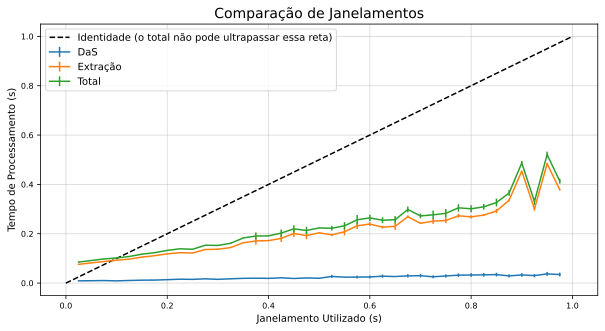

In [24]:
# CRIANDO OS ARRAYS DE TEMPO MEDIO E DESVIO PADRAO
# DaS
arrayTempoMedioDaSCadaJanelamento        = []
arrayDesvioPadraoDaSCadaJanelamento      = []
# Extracao
arrayTempoMedioExtracaoCadaJanelamento   = []
arrayDesvioPadraoExtracaoCadaJanelamento = []
# Total
arrayTempoMedioTotalCadaJanelamento      = []
arrayDesvioPadraoTotalCadaJanelamento    = []

for i in range(len(janelamentos)):
    # DaS
    arrayTempoMedioDaSCadaJanelamento.append(np.mean(matrizTemposDaS[i]))
    arrayDesvioPadraoDaSCadaJanelamento.append(np.std(matrizTemposDaS[i]))
    # Extracao
    arrayTempoMedioExtracaoCadaJanelamento.append(np.mean(matrizTemposExtracao[i]))
    arrayDesvioPadraoExtracaoCadaJanelamento.append(np.std(matrizTemposExtracao[i]))
    # Total
    arrayTempoMedioTotalCadaJanelamento.append(np.mean(matrizTemposTotal[i]))
    arrayDesvioPadraoTotalCadaJanelamento.append(np.std(matrizTemposTotal[i]))
    
# PRINTANDO
plt.plot([0, 1], [0, 1], "--", color="black", label="Identidade (o total não pode ultrapassar essa reta)")
plt.errorbar(janelamentos, arrayTempoMedioDaSCadaJanelamento, yerr=arrayDesvioPadraoDaSCadaJanelamento, label="DaS")
plt.errorbar(janelamentos, arrayTempoMedioExtracaoCadaJanelamento, yerr=arrayDesvioPadraoExtracaoCadaJanelamento, label="Extração")
plt.errorbar(janelamentos, arrayTempoMedioTotalCadaJanelamento, yerr=arrayDesvioPadraoTotalCadaJanelamento, label="Total")
plt.xlabel("Janelamento Utilizado (s)")
plt.ylabel("Tempo de Processamento (s)")
plt.title("Comparação de Janelamentos")
plt.grid(alpha=0.5)
plt.legend()
plt.show()